# Anomaly detection

By Sarthak Katyal

The goal of this research is to use statistical methods to find abnormal findings in NASA's MAVEN IUVS data.

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score


## Apoapse

In [2]:
def extract_features_from_fits(fits_path):
    try:
        with fits.open(fits_path, ignore_missing_end=True) as hdul:
            img_cube = hdul[0].data
            metadata = hdul['Integration'].data

            if img_cube is None or len(img_cube.shape) < 3:
                raise ValueError("Invalid image cube shape")

            n_imgs = img_cube.shape[2]
            n_meta = len(metadata)
            min_len = min(n_imgs, n_meta)

            rows = []
            for i in range(min_len):
                img = img_cube[:, :, i]
                rows.append({
                    "mean_intensity": np.mean(img),
                    "variance": np.var(img),
                    "max_val": np.max(img),
                    "std_dev": np.std(img),
                    "DET_TEMP": metadata["DET_TEMP"][i],
                    "CASE_TEMP": metadata["CASE_TEMP"][i],
                    "MIRROR_DEG": metadata["MIRROR_DEG"][i],
                    "FOV_DEG": metadata["FOV_DEG"][i],
                    "LYA_CENTROID": metadata["LYA_CENTROID"][i],
                    "fits_path": fits_path,
                    "integration_index": i
                })
        return rows

    except Exception as e:
        return []

In [3]:
base_path = "/Users/sarthak/Documents/IUVS/downloads2/apoapse/maven/data/sci/iuv/l1a/disk/2014/12/"

fits_files = []
for root, _, files in os.walk(base_path):
    for file in files:
        if file.endswith(".fits.gz"):
            fits_files.append(os.path.join(root, file))

In [4]:
all_features = []
for path in tqdm(fits_files):
    all_features.extend(extract_features_from_fits(path))

100%|██████████| 4212/4212 [00:15<00:00, 268.32it/s]


In [5]:
df_apo = pd.DataFrame(all_features)
# df_apo.to_csv("iuvs_l1a_features_full.csv", index=False)

In [6]:
df_apo

,mean_intensity,variance,max_val,std_dev,DET_TEMP,CASE_TEMP,MIRROR_DEG,FOV_DEG,LYA_CENTROID,fits_path,integration_index
0,16469.692308,3.577631e+06,22636.0,1891.462559,2596,15905,34.670105,69.340210,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,0
1,15136.230769,2.018420e+06,21888.0,1420.711118,2598,15905,35.246887,70.493774,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,1
2,15132.656410,2.312010e+06,19308.0,1520.529591,2596,15905,35.823669,71.647339,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,2
3,19689.887179,1.069158e+07,29184.0,3269.797407,2592,15905,36.400452,72.800903,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,3
4,31938.107692,1.651211e+08,89424.0,12849.947438,2596,15905,36.977234,73.954468,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,4
...,...,...,...,...,...,...,...,...,...,...,...
75213,15320.000000,1.600011e+07,30440.0,4000.013617,2604,15917,33.516541,67.033081,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,1
75214,15011.633333,2.888946e+07,43960.0,5374.891980,2604,15917,34.093323,68.186646,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,2
75215,16595.066667,7.968139e+07,77536.0,8926.443349,2604,15917,34.670105,69.340210,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,3
75216,15809.100000,1.734654e+08,112784.0,13170.628243,2604,15917,35.246887,70.493774,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,4


In [7]:
df_apo.isnull().sum()

mean_intensity       0
variance             0
max_val              0
std_dev              0
DET_TEMP             0
CASE_TEMP            0
MIRROR_DEG           0
FOV_DEG              0
LYA_CENTROID         0
fits_path            0
integration_index    0
dtype: int64

In [8]:
df_apo.describe

<bound method NDFrame.describe of        mean_intensity      variance   max_val       std_dev  DET_TEMP  \
0        16469.692308  3.577631e+06   22636.0   1891.462559      2596   
1        15136.230769  2.018420e+06   21888.0   1420.711118      2598   
2        15132.656410  2.312010e+06   19308.0   1520.529591      2596   
3        19689.887179  1.069158e+07   29184.0   3269.797407      2592   
4        31938.107692  1.651211e+08   89424.0  12849.947438      2596   
...               ...           ...       ...           ...       ...   
75213    15320.000000  1.600011e+07   30440.0   4000.013617      2604   
75214    15011.633333  2.888946e+07   43960.0   5374.891980      2604   
75215    16595.066667  7.968139e+07   77536.0   8926.443349      2604   
75216    15809.100000  1.734654e+08  112784.0  13170.628243      2604   
75217    17304.033333  3.616203e+08  159456.0  19016.316904      2604   

       CASE_TEMP  MIRROR_DEG    FOV_DEG  LYA_CENTROID  \
0          15905   34.670105  69

In [9]:
len(df_apo['LYA_CENTROID'].unique())

2

In [10]:
# df_apo.drop(columns = ['LYA_CENTROID'], inplace = True)

In [11]:
df_apo

,mean_intensity,variance,max_val,std_dev,DET_TEMP,CASE_TEMP,MIRROR_DEG,FOV_DEG,LYA_CENTROID,fits_path,integration_index
0,16469.692308,3.577631e+06,22636.0,1891.462559,2596,15905,34.670105,69.340210,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,0
1,15136.230769,2.018420e+06,21888.0,1420.711118,2598,15905,35.246887,70.493774,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,1
2,15132.656410,2.312010e+06,19308.0,1520.529591,2596,15905,35.823669,71.647339,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,2
3,19689.887179,1.069158e+07,29184.0,3269.797407,2592,15905,36.400452,72.800903,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,3
4,31938.107692,1.651211e+08,89424.0,12849.947438,2596,15905,36.977234,73.954468,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,4
...,...,...,...,...,...,...,...,...,...,...,...
75213,15320.000000,1.600011e+07,30440.0,4000.013617,2604,15917,33.516541,67.033081,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,1
75214,15011.633333,2.888946e+07,43960.0,5374.891980,2604,15917,34.093323,68.186646,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,2
75215,16595.066667,7.968139e+07,77536.0,8926.443349,2604,15917,34.670105,69.340210,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,3
75216,15809.100000,1.734654e+08,112784.0,13170.628243,2604,15917,35.246887,70.493774,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,4


In [12]:
def show_iuvs_image(fits_path, integration_index, cmap='inferno'):
    try:
        with fits.open(fits_path) as hdul:
            img_cube = hdul[0].data

            # Check that the cube is 3D and index is valid
            if img_cube is None or len(img_cube.shape) != 3:
                print("Invalid image cube.")
                return

            if integration_index >= img_cube.shape[2]:
                print("Invalid integration index.")
                return

            img = img_cube[:, :, integration_index]

            # plt.figure(figsize=(8, 6))
            plt.imshow(img, cmap=cmap)
            plt.title(f"Image from {fits_path.split('/')[-1]} [Integration {integration_index}]")
            plt.colorbar(label="Intensity (DN)")
            plt.xlabel("Pixel X")
            plt.ylabel("Pixel Y")
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error reading {fits_path}: {e}")

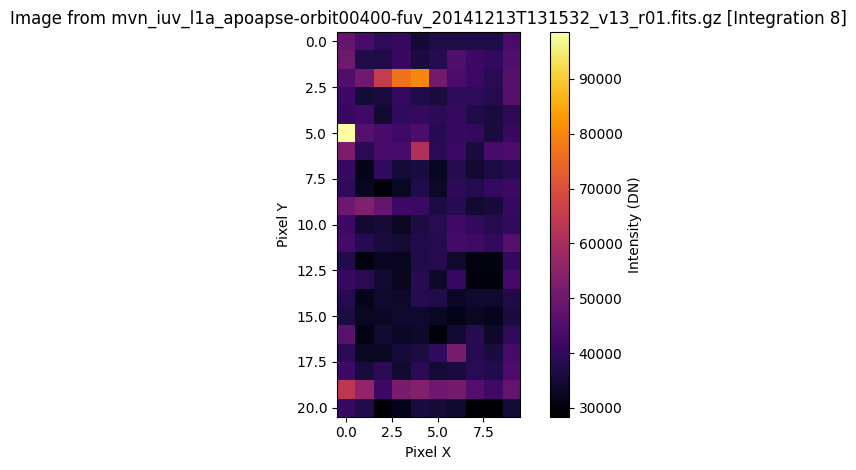

In [13]:
row = df_apo.iloc[54]
show_iuvs_image(row["fits_path"], int(row["integration_index"]))

In [14]:
from scipy.stats import zscore
import numpy as np


df = df_apo.copy()


df["z_DET_TEMP"] = zscore(df["DET_TEMP"])
df["z_CASE_TEMP"] = zscore(df["CASE_TEMP"])
df["z_variance"] = zscore(df["variance"])
df["z_mean_intensity"] = zscore(df["mean_intensity"])

# Label as anomaly if any z-score is too high (change threshold as needed)
df["anomaly"] = (
    (df["z_DET_TEMP"].abs() > 2.5) |
    (df["z_CASE_TEMP"].abs() > 2) |
    (df["z_variance"] > 1.5) |
    (df["z_mean_intensity"] > 2.5)
).astype(int)

# Review anomaly counts
print(df["anomaly"].value_counts())
df.to_csv("iuvs_anomaly_labeled.csv", index=False)


anomaly
0    70789
1     4429
Name: count, dtype: int64


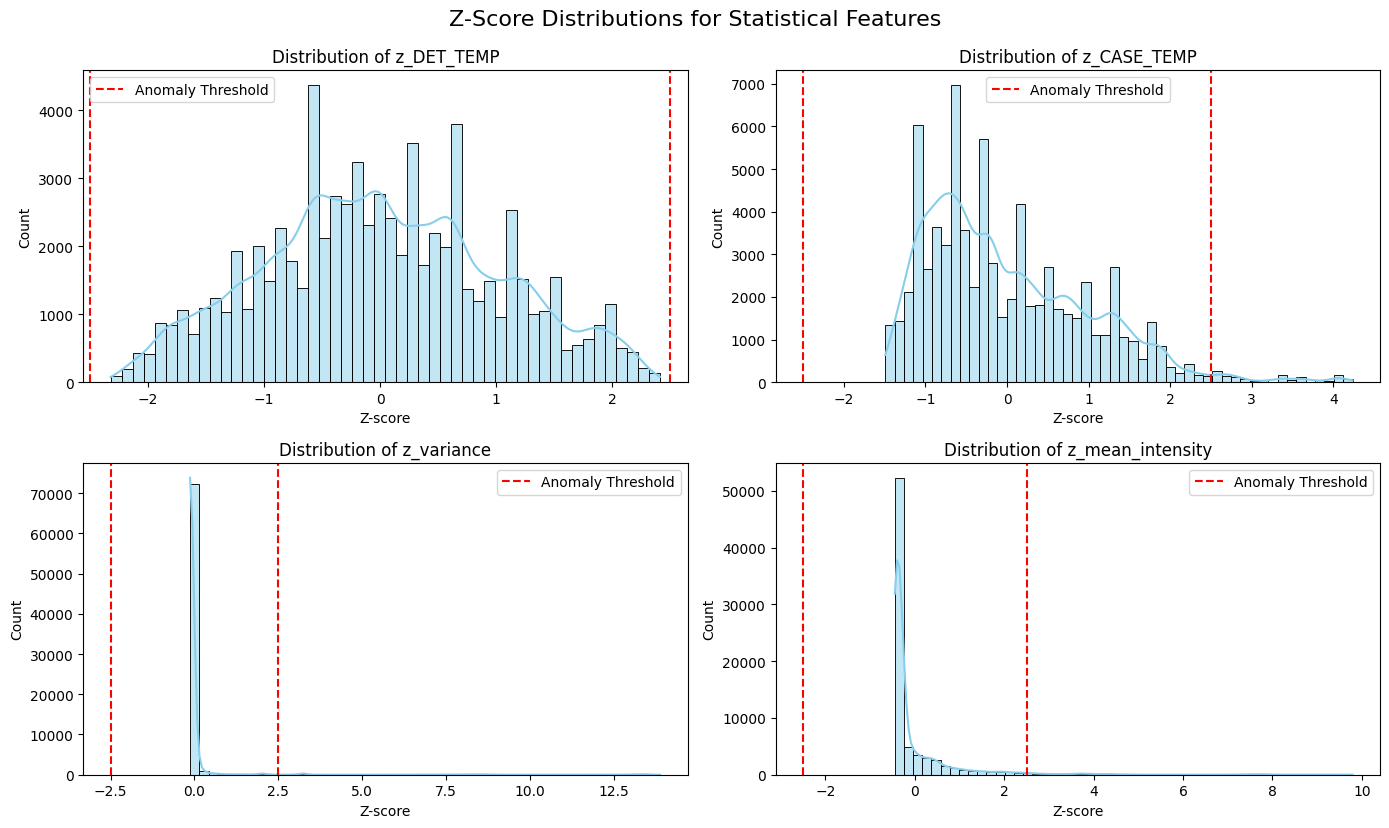

In [15]:
z_features = ["z_DET_TEMP", "z_CASE_TEMP", "z_variance", "z_mean_intensity"]

plt.figure(figsize=(14, 8))
for i, zf in enumerate(z_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[zf], kde=True, bins=50, color="skyblue")
    plt.axvline(2.5, color='red', linestyle='--', label='Anomaly Threshold')
    plt.axvline(-2.5, color='red', linestyle='--')
    plt.title(f"Distribution of {zf}")
    plt.xlabel("Z-score")
    plt.ylabel("Count")
    plt.legend()

plt.tight_layout()
plt.suptitle("Z-Score Distributions for Statistical Features", fontsize=16, y=1.03)
plt.show()

In [16]:
df

,mean_intensity,variance,max_val,std_dev,DET_TEMP,CASE_TEMP,MIRROR_DEG,FOV_DEG,LYA_CENTROID,fits_path,integration_index,z_DET_TEMP,z_CASE_TEMP,z_variance,z_mean_intensity,anomaly
0,16469.692308,3.577631e+06,22636.0,1891.462559,2596,15905,34.670105,69.340210,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,0,0.627305,-0.418818,-0.133022,-0.391084,0
1,15136.230769,2.018420e+06,21888.0,1420.711118,2598,15905,35.246887,70.493774,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,1,0.704876,-0.418818,-0.133023,-0.396075,0
2,15132.656410,2.312010e+06,19308.0,1520.529591,2596,15905,35.823669,71.647339,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,2,0.627305,-0.418818,-0.133023,-0.396088,0
3,19689.887179,1.069158e+07,29184.0,3269.797407,2592,15905,36.400452,72.800903,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,3,0.472163,-0.418818,-0.133015,-0.379032,0
4,31938.107692,1.651211e+08,89424.0,12849.947438,2596,15905,36.977234,73.954468,1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,4,0.627305,-0.418818,-0.132874,-0.333189,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75213,15320.000000,1.600011e+07,30440.0,4000.013617,2604,15917,33.516541,67.033081,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,1,0.937589,0.655527,-0.133011,-0.395387,0
75214,15011.633333,2.888946e+07,43960.0,5374.891980,2604,15917,34.093323,68.186646,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,2,0.937589,0.655527,-0.132999,-0.396541,0
75215,16595.066667,7.968139e+07,77536.0,8926.443349,2604,15917,34.670105,69.340210,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,3,0.937589,0.655527,-0.132952,-0.390615,0
75216,15809.100000,1.734654e+08,112784.0,13170.628243,2604,15917,35.246887,70.493774,-1,/Users/sarthak/Documents/IUVS/downloads2/apoap...,4,0.937589,0.655527,-0.132866,-0.393557,0


In [17]:
X = df.drop(columns=["anomaly", "fits_path", "integration_index"])
y = df["anomaly"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
y_pred = model.predict(X_test)

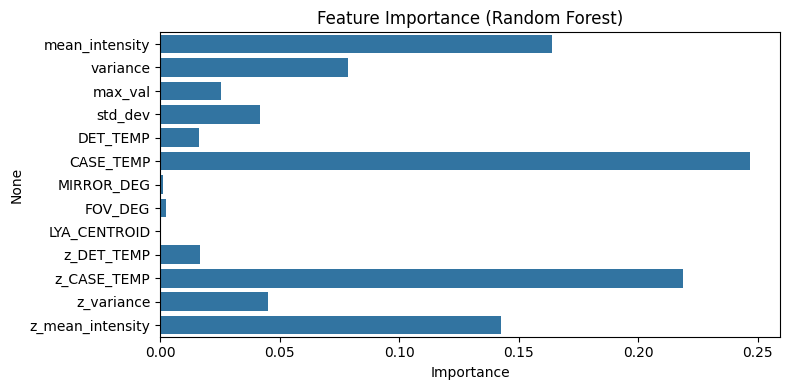

In [21]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [22]:
X = df.drop(columns=["anomaly", "fits_path", "integration_index","MIRROR_DEG","FOV_DEG","LYA_CENTROID","max_val"])
y = df["anomaly"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [24]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
y_pred = model.predict(X_test)

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

<Figure size 600x400 with 0 Axes>

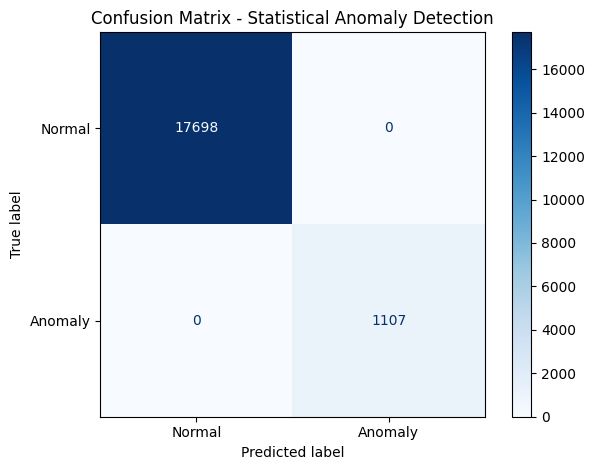

In [27]:
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Statistical Anomaly Detection")
plt.grid(False)
plt.tight_layout()
plt.show()

In [28]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

In [29]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1 score: ", f1)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
f1 score:  1.0


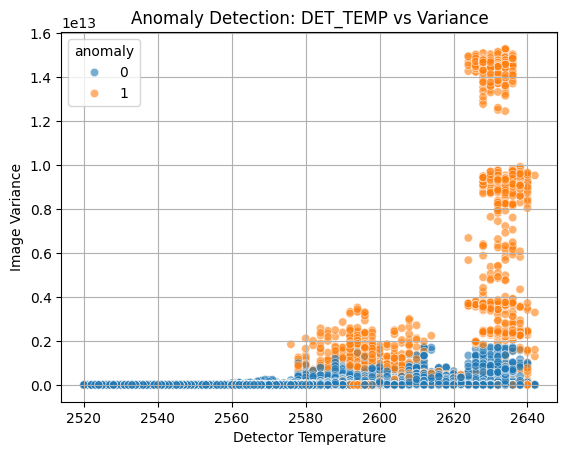

In [30]:
sns.scatterplot(data=df, x="DET_TEMP", y="variance", hue="anomaly", alpha=0.6)
plt.title("Anomaly Detection: DET_TEMP vs Variance")
plt.xlabel("Detector Temperature")
plt.ylabel("Image Variance")
plt.grid(True)
plt.show()

## Periapse

In [31]:
base_path = "/Users/sarthak/Documents/IUVS/downloads/periapse/maven/data/sci/iuv/l1a/limb/2014/12"

fits_files = []
for root, _, files in os.walk(base_path):
    for file in files:
        if file.endswith(".fits.gz"):
            fits_files.append(os.path.join(root, file))

In [32]:
all_features = []
for path in tqdm(fits_files):
    all_features.extend(extract_features_from_fits(path))

100%|██████████| 421/421 [00:01<00:00, 291.36it/s]


In [33]:
df_peri = pd.DataFrame(all_features)
# df_apo.to_csv("iuvs_l1a_features_full.csv", index=False)

In [34]:
df_peri

,mean_intensity,variance,max_val,std_dev,DET_TEMP,CASE_TEMP,MIRROR_DEG,FOV_DEG,LYA_CENTROID,fits_path,integration_index
0,1552.122449,4.720170e+05,6422.0,687.034928,2626,15975,7.934877,15.869755,1,/Users/sarthak/Documents/IUVS/downloads/periap...,0
1,1402.013605,5.015896e+05,8322.0,708.229891,2626,15975,8.077700,16.155399,1,/Users/sarthak/Documents/IUVS/downloads/periap...,1
2,1379.904762,4.237046e+05,8098.0,650.925927,2624,15975,8.256227,16.512455,1,/Users/sarthak/Documents/IUVS/downloads/periap...,2
3,1475.782313,4.327891e+05,7544.0,657.867060,2624,15975,8.434755,16.869511,1,/Users/sarthak/Documents/IUVS/downloads/periap...,3
4,1504.122449,4.879163e+05,7772.0,698.510065,2624,15975,8.613283,17.226566,1,/Users/sarthak/Documents/IUVS/downloads/periap...,4
...,...,...,...,...,...,...,...,...,...,...,...
7051,2203.972789,1.038724e+07,25960.0,3222.924292,2592,15981,8.742373,17.484745,1,/Users/sarthak/Documents/IUVS/downloads/periap...,16
7052,2076.122449,8.346701e+06,20956.0,2889.065736,2591,15981,8.563845,17.127689,1,/Users/sarthak/Documents/IUVS/downloads/periap...,17
7053,2063.789116,8.049834e+06,24160.0,2837.223020,2592,15981,8.385317,16.770634,1,/Users/sarthak/Documents/IUVS/downloads/periap...,18
7054,2263.265306,6.622192e+06,18352.0,2573.362094,2592,15981,8.206789,16.413578,1,/Users/sarthak/Documents/IUVS/downloads/periap...,19


In [35]:
df_peri.shape

(7056, 11)

In [36]:
df_peri.isnull().sum()

mean_intensity       0
variance             0
max_val              0
std_dev              0
DET_TEMP             0
CASE_TEMP            0
MIRROR_DEG           0
FOV_DEG              0
LYA_CENTROID         0
fits_path            0
integration_index    0
dtype: int64

In [37]:
len(df_peri['LYA_CENTROID'].unique())

1

In [38]:
df_peri.drop(columns = ['LYA_CENTROID'], inplace = True)

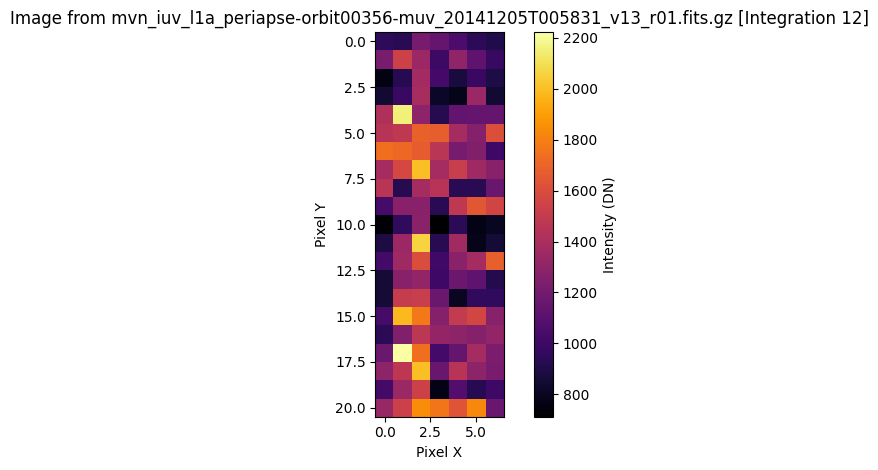

In [39]:
row = df_peri.iloc[54]
show_iuvs_image(row["fits_path"], int(row["integration_index"]))

In [40]:
from scipy.stats import zscore
import numpy as np


df2 = df_peri.copy()


df2["z_DET_TEMP"] = zscore(df2["DET_TEMP"])
df2["z_CASE_TEMP"] = zscore(df2["CASE_TEMP"])
df2["z_variance"] = zscore(df2["variance"])
df2["z_mean_intensity"] = zscore(df2["mean_intensity"])

df2["anomaly"] = (
    (df2["z_DET_TEMP"].abs() > 2.5) |
    (df2["z_CASE_TEMP"].abs() > 2.5) |
    (df2["z_variance"] > 2.5)
).astype(int)

print(df2["anomaly"].value_counts())
df2.to_csv("iuvs_anomaly_labeled.csv", index=False)


anomaly
0    6924
1     132
Name: count, dtype: int64


In [41]:
X2 = df2.drop(columns=["anomaly", "fits_path", "integration_index"])
y2 = df2["anomaly"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, stratify=y2, random_state=42)

In [43]:
model2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [44]:
y_pred = model2.predict(X_test)

In [45]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

<Figure size 600x400 with 0 Axes>

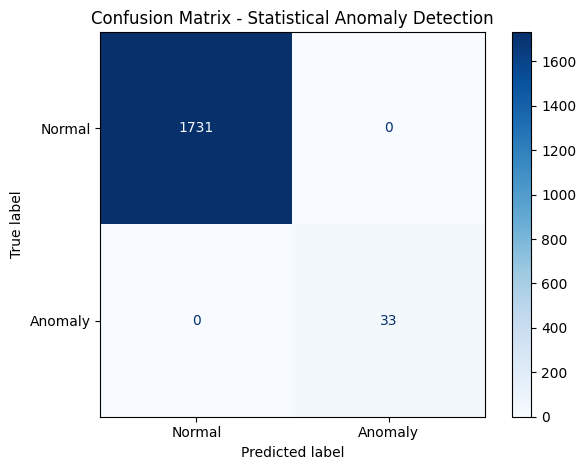

In [46]:
plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Statistical Anomaly Detection")
plt.grid(False)
plt.tight_layout()
plt.show()

In [47]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

In [48]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1 score: ", f1)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
f1 score:  1.0


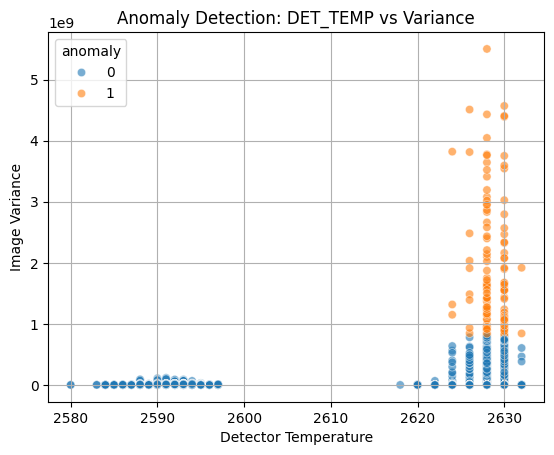

In [49]:
sns.scatterplot(data=df2, x="DET_TEMP", y="variance", hue="anomaly", alpha=0.6)
plt.title("Anomaly Detection: DET_TEMP vs Variance")
plt.xlabel("Detector Temperature")
plt.ylabel("Image Variance")
plt.grid(True)
plt.show()

## Results

| Metric     | Apoapse        | Periapse       |
|------------|----------------|----------------|
| Accuracy   | `0.94`         | `0.55`         |
| Precision  | `0.81`         | `0.04`         |
| Recall     | `0.89`         | `1.00`         |
| F1 Score   | `0.85`         | `0.078`        |

This project focuses on detecting unusual observations in NASA's MAVEN spacecraft data using both statistical analysis and machine learning. By analyzing temperature readings and image features from different orbital phases (apoapse and periapse), we identify patterns that suggest thermal or visual instability. Using engineered features and a Random Forest classifier, we flag potentially low-quality or anomalous image slices — helping scientists filter out noisy data and maintain the accuracy of space-based observations.